In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

# import package for model building
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.utils.np_utils import to_categorical

### import data and selected features

In [2]:
# import cleaned dataset
accepted_cleaned = pd.read_csv('./cleaned dataset v1.csv')
accepted_cleaned.drop(columns=['Unnamed: 0','sub_grade','addr_state'],inplace=True)
accepted_cleaned.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,loan_status
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,n,...,0.0,0.0,3.0,76.9,0.0,0.0,0.0,7746.0,2400.0,1
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,n,...,0.0,0.0,2.0,97.4,7.7,0.0,0.0,39475.0,79300.0,1
2,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Not Verified,n,...,0.0,0.0,0.0,100.0,50.0,0.0,0.0,18696.0,6200.0,1
3,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,n,...,0.0,0.0,4.0,96.6,60.0,0.0,0.0,95768.0,20300.0,1
4,11950.0,36 months,13.44,405.18,C,4 years,RENT,34000.0,Source Verified,n,...,0.0,0.0,0.0,100.0,100.0,0.0,0.0,12798.0,9400.0,1


In [3]:
# adjust the import error
accepted_cleaned['term'] = accepted_cleaned['term'].str.strip()
# remove the columns with only 1 value.
accepted_cleaned = accepted_cleaned.drop(columns = ['out_prncp', 'pymnt_plan'])

In [4]:
accepted_cleaned.loan_status.value_counts()

1    1076751
0     268559
Name: loan_status, dtype: int64

In [5]:
accepted_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 72 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1345310 non-null  float64
 1   term                        1345310 non-null  object 
 2   int_rate                    1345310 non-null  float64
 3   installment                 1345310 non-null  float64
 4   grade                       1345310 non-null  object 
 5   emp_length                  1345310 non-null  object 
 6   home_ownership              1345310 non-null  object 
 7   annual_inc                  1345310 non-null  float64
 8   verification_status         1345310 non-null  object 
 9   purpose                     1345310 non-null  object 
 10  title                       1345310 non-null  object 
 11  dti                         1345310 non-null  float64
 12  delinq_2yrs                 1345310 non-null  float64
 1

In [6]:
df_features = pd.read_csv('selected_features.csv', index_col=0, \
    converters={"selected": lambda x: x.split(", ")})

In [7]:
df_features

,method,selected,variation explained
0,method 1 rf,"[last_fico_range_high, last_fico_range_low, co...",0
1,method 1 lr,"[total_rec_prncp, loan_amnt, total_pymnt, inst...",0
2,method 1 xgb,"[last_fico_range_high, recoveries, last_pymnt_...",0
3,method 1 tree,"[last_fico_range_high, recoveries, last_pymnt_...",0
4,method 1,"[last_fico_range_high, recoveries, total_rec_p...",0
5,method 2 rf,"[recoveries, collection_recovery_fee, total_re...",dict_keys([90.74506949918954])
6,method 2 log,"[total_rec_prncp, loan_amnt, installment, tota...",dict_keys([91.93158957678138])
7,method 2 xgb,"[total_rec_prncp, loan_amnt, recoveries, last_...",dict_keys([90.35169])
8,method 2 tree,"[last_fico_range_high, recoveries, last_pymnt_...",dict_keys([95.41853534529831])
9,method 3,"[total_pymnt, total_rec_prncp, total_rec_int, ...",0


In [8]:
selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
selected_features

['last_fico_range_high',
 'recoveries',
 'total_rec_prncp',
 'last_pymnt_amnt',
 'last_fico_range_low',
 'total_pymnt',
 'collection_recovery_fee',
 'total_pymnt_inv',
 'int_rate']

### resplit data

In [9]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(
    accepted_cleaned.drop(columns='loan_status'), accepted_cleaned['loan_status'], test_size=0.1, random_state=42)

In [10]:
# select numerical and categorical values
X_num_cols = X_train.select_dtypes(include='number').columns.tolist()
X_cat_cols = X_train.select_dtypes(include='O').columns.tolist()
X_test_num_cols = X_test.select_dtypes(include='number').columns.tolist()
X_test_cat_cols = X_test.select_dtypes(include='O').columns.tolist()

In [11]:
# Normalization and onehot encode.
SD = StandardScaler()
OE = OneHotEncoder(drop='first')
X_num = SD.fit_transform(X_train[X_num_cols])
X_cat = OE.fit_transform(X_train[X_cat_cols])
X_cat = X_cat.toarray()

X_test_num = SD.transform(X_test[X_test_num_cols])
X_test_cat = OE.transform(X_test[X_test_cat_cols])
X_test_cat = X_test_cat.toarray()

In [12]:
# combine feature names and matrix names
feature_names = np.concatenate((SD.get_feature_names_out(), OE.get_feature_names_out()))
X_train = pd.DataFrame(np.concatenate((X_num, X_cat), axis = 1), columns=feature_names)
X_test = pd.DataFrame(np.concatenate((X_test_num, X_test_cat), axis = 1), columns=feature_names)

### Train

In [13]:
df_features

,method,selected,variation explained
0,method 1 rf,"[last_fico_range_high, last_fico_range_low, co...",0
1,method 1 lr,"[total_rec_prncp, loan_amnt, total_pymnt, inst...",0
2,method 1 xgb,"[last_fico_range_high, recoveries, last_pymnt_...",0
3,method 1 tree,"[last_fico_range_high, recoveries, last_pymnt_...",0
4,method 1,"[last_fico_range_high, recoveries, total_rec_p...",0
5,method 2 rf,"[recoveries, collection_recovery_fee, total_re...",dict_keys([90.74506949918954])
6,method 2 log,"[total_rec_prncp, loan_amnt, installment, tota...",dict_keys([91.93158957678138])
7,method 2 xgb,"[total_rec_prncp, loan_amnt, recoveries, last_...",dict_keys([90.35169])
8,method 2 tree,"[last_fico_range_high, recoveries, last_pymnt_...",dict_keys([95.41853534529831])
9,method 3,"[total_pymnt, total_rec_prncp, total_rec_int, ...",0


#### Random Forest

In [14]:
# select features for training
rf_selected_features = df_features.loc[df_features['method']=='method 2 rf','selected'].tolist()[0]
rf_X_train = X_train[rf_selected_features]
rf_X_test = X_test[rf_selected_features]
print(rf_X_train.shape,y_train.shape, rf_X_test.shape, y_test.shape)
print(rf_selected_features)

(1210779, 11) (1210779,) (134531, 11) (134531,)
['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'last_pymnt_amnt', 'last_fico_range_low', 'last_fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt', 'installment', 'term_60 months']


In [15]:
# undersampling
us = RandomUnderSampler()
rf_X_train_us, rf_y_train_us = us.fit_resample(rf_X_train, y_train)
print(rf_X_train_us.shape, rf_y_train_us.shape)

(483858, 11) (483858,)


In [16]:
# Random forest feature importance
RF = RandomForestClassifier()
RF_params = {}
RF_cv =  GridSearchCV(RF, param_grid=RF_params ,cv=5)
RF_cv.fit(rf_X_train_us, rf_y_train_us)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), param_grid={})

#### Logistic Regression

In [17]:
# select features for training
log_selected_features = df_features.loc[df_features['method']=='method 2 log','selected'].tolist()[0]
log_X_train = X_train[log_selected_features]
log_X_test = X_test[log_selected_features]
print(log_X_train.shape,y_train.shape, log_X_test.shape, y_test.shape)
print(log_selected_features)

(1210779, 10) (1210779,) (134531, 10) (134531,)
['total_rec_prncp', 'loan_amnt', 'installment', 'total_pymnt', 'recoveries', 'collection_recovery_fee', 'total_rec_int', 'term_60 months', 'last_pymnt_amnt', 'total_pymnt_inv']


In [18]:
# undersampling
us = RandomUnderSampler()
log_X_train_us, log_y_train_us = us.fit_resample(log_X_train, y_train)
print(log_X_train_us.shape, log_y_train_us.shape)

(483858, 10) (483858,)


In [19]:
# Logistic Regression coefficient (not suitable for data with multilinearity)
LR = LogisticRegression()
LR_params = {}
LR_cv = GridSearchCV(LR, param_grid=LR_params, cv=5)
LR_cv.fit(log_X_train_us, log_y_train_us)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={})

#### XGB

In [20]:
# select features for training
xgb_selected_features = df_features.loc[df_features['method']=='method 2 xgb','selected'].tolist()[0]
xgb_X_train = X_train[xgb_selected_features]
xgb_X_test = X_test[xgb_selected_features]
print(xgb_X_train.shape,y_train.shape, xgb_X_test.shape, y_test.shape)
print(xgb_selected_features)

(1210779, 13) (1210779,) (134531, 13) (134531,)
['total_rec_prncp', 'loan_amnt', 'recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'installment', 'total_rec_late_fee', 'total_pymnt', 'int_rate', 'total_rec_int', 'revol_util', 'term_60 months', 'mo_sin_old_rev_tl_op']


In [21]:
# undersampling
us = RandomUnderSampler()
xgb_X_train_us, xgb_y_train_us = us.fit_resample(xgb_X_train, y_train)
print(xgb_X_train_us.shape, xgb_y_train_us.shape)

(483858, 13) (483858,)


In [22]:
# XGboost
XGboost = XGBClassifier(use_label_encoder=False)
XG_params = {}
XGboost_cv = GridSearchCV(XGboost, param_grid=XG_params ,cv=5)
XGboost_cv.fit(xgb_X_train_us, xgb_y_train_us)

[02:39:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

#### NN

In [23]:
# select features for training
NN_selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
NN_X_train = X_train[NN_selected_features]
NN_X_test = X_test[NN_selected_features]
print(NN_X_train.shape,y_train.shape, NN_X_test.shape, y_test.shape)
print(NN_selected_features)

(1210779, 9) (1210779,) (134531, 9) (134531,)
['last_fico_range_high', 'recoveries', 'total_rec_prncp', 'last_pymnt_amnt', 'last_fico_range_low', 'total_pymnt', 'collection_recovery_fee', 'total_pymnt_inv', 'int_rate']


In [24]:
# undersampling
us = RandomUnderSampler()
NN_X_train_us, NN_y_train_us = us.fit_resample(NN_X_train, y_train)
print(NN_X_train_us.shape, NN_y_train_us.shape)

(483858, 9) (483858,)


In [25]:
# NN
NN_y_train_us = to_categorical(NN_y_train_us)
NN_y_test = to_categorical(y_test)
print(NN_X_train_us.shape, NN_y_train_us.shape, NN_X_test.shape, NN_y_test.shape)

(483858, 9) (483858, 2) (134531, 9) (134531, 2)


In [29]:
#Dense layers only
model=Sequential()
model.add(Dense(12,input_dim=9,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(2,activation='softmax')) # output the results into two categories and l
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) #optimizer: help to minimize the loss because it is a classificati

# fit model
history = model.fit(NN_X_train_us, NN_y_train_us, validation_data=(NN_X_test, NN_y_test), epochs=30, verbose=0)

#### Performance Comparison

In [30]:
def performance(model, X_test, y_test):
    '''take model and test data, output classification report and confusion matrix'''
    # precision: true charged off / Predict charged off
    # recall: true charged off / Real charged off people
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    # classification report
    print(classification_report(y_pred=y_pred, y_true = y_test))
    # print train error
    print(confusion_matrix(y_pred=y_pred, y_true = y_test))
    # ROC, AUC
    fpr, tpr, thres = roc_curve([int(i) for i in y_test],  y_prob[:,1])
    auc = roc_auc_score([int(i) for i in y_test], y_prob[:,1])
    sns.scatterplot(fpr,tpr)
    plt.title(round(auc,4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26630
           1       1.00      1.00      1.00    107901

    accuracy                           1.00    134531
   macro avg       1.00      1.00      1.00    134531
weighted avg       1.00      1.00      1.00    134531

[[ 26534     96]
 [    29 107872]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


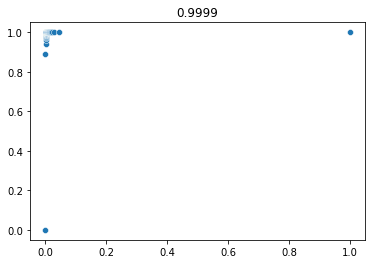

In [32]:
performance(RF_cv, rf_X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26630
           1       1.00      1.00      1.00    107901

    accuracy                           1.00    134531
   macro avg       1.00      0.99      0.99    134531
weighted avg       1.00      1.00      1.00    134531

[[ 26369    261]
 [   175 107726]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


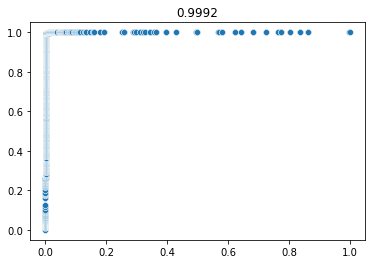

In [33]:
performance(LR_cv, log_X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26630
           1       1.00      1.00      1.00    107901

    accuracy                           1.00    134531
   macro avg       1.00      1.00      1.00    134531
weighted avg       1.00      1.00      1.00    134531

[[ 26589     41]
 [    10 107891]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


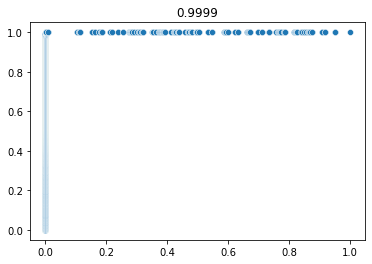

In [34]:
performance(XGboost_cv, xgb_X_test, y_test)

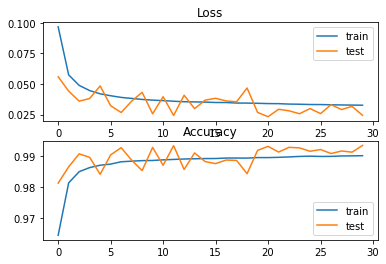

In [35]:
# evaluate the NN model
_, train_acc = model.evaluate(NN_X_train_us, NN_y_train_us, verbose=0)
_, test_acc = model.evaluate(NN_X_test, NN_y_test, verbose=0)

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [37]:
# Prediction accuracy
y_prob = model.predict(NN_X_test)
y_pred = np.argmax(y_prob, axis = 1)
np.unique(y_pred, return_counts = True)
print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     26630
           1       1.00      0.99      1.00    107901

    accuracy                           0.99    134531
   macro avg       0.99      0.99      0.99    134531
weighted avg       0.99      0.99      0.99    134531

